# Método de Ondas Planas 2D

Programa para el cálculo de estructura de bandas en cristales fotónicos 2D

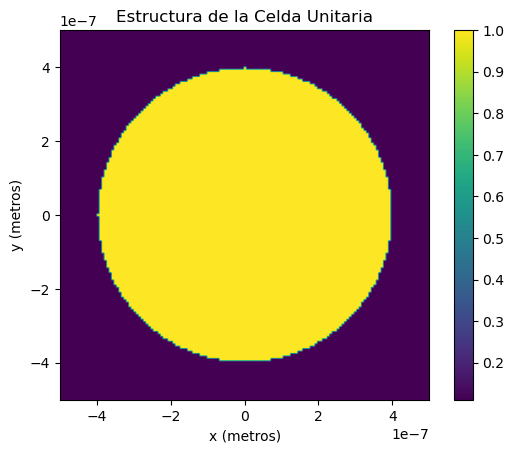

C:\Users\Dell\AppData\Local\Temp\ipykernel_23088\2165794073.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  dispe[:, countK] = np.sqrt(eigenvalues) * a / (2 * np.pi)


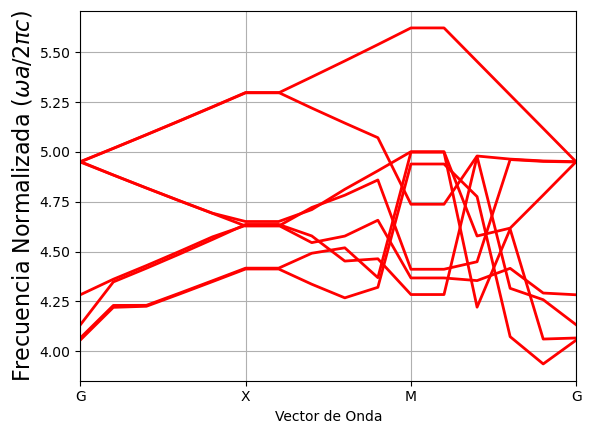

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Definir constantes
a = 1e-6
r = 0.4 * a
eps1 = 9
eps2 = 1
precis = 5
nG = 4
precisStruct = 150

# Inicializar struct y coordenadas
struct = np.zeros((precisStruct+1, precisStruct+1))
xSet = np.linspace(-a/2, a/2, precisStruct+1)
ySet = np.linspace(-a/2, a/2, precisStruct+1)

# Definir celda unitaria
nx = 0
for countX in np.arange(-a/2, a/2 + a/precisStruct, a/precisStruct):
    ny = 0
    for countY in np.arange(-a/2, a/2 + a/precisStruct, a/precisStruct):
        if np.sqrt(countX**2 + countY**2) < r:
            struct[nx, ny] = 1/eps2
        else:
            struct[nx, ny] = 1/eps1
        ny += 1
    nx += 1

# Plot struct
plt.imshow(struct, extent=[-a/2, a/2, -a/2, a/2], cmap='viridis')
plt.colorbar()
plt.title('Estructura de la Celda Unitaria')
plt.xlabel('x (metros)')
plt.ylabel('y (metros)')
plt.show()

# Calcular el área de la celda de malla
dS = (a/precisStruct)**2

# Formar matrices 2D de coordenadas de nodos
xMesh, yMesh = np.meshgrid(xSet[:-1], ySet[:-1])

# Transformar valores de la función dieléctrica inversa
structMesh = struct[:-1, :-1] * dS / (max(xSet) - min(xSet))**2

# Definir la trayectoria k dentro de la zona de Brillouin
kx = np.concatenate((np.linspace(0, np.pi/a, precis+1),
                     np.full(precis, np.pi/a),
                     np.linspace(np.pi/a, 0, precis)))

ky = np.concatenate((np.zeros(precis+1),
                     np.linspace(0, np.pi/a, precis),
                     np.linspace(np.pi/a, 0, precis)))

# Formar el conjunto de vectores de la red recíproca
G = []
numG = 0
for Gx in np.arange(-nG*2*np.pi/a, nG*2*np.pi/a + 2*np.pi/a, 2*np.pi/a):
    for Gy in np.arange(-nG*2*np.pi/a, nG*2*np.pi/a + 2*np.pi/a, 2*np.pi/a):
        G.append([Gx, Gy])
        numG += 1

# Computar los coeficientes de expansión de Fourier
CN2D_N = np.zeros((numG, numG), dtype=complex)
for countG in range(numG):
    for countG1 in range(numG):
        CN2D_N[countG, countG1] = np.sum(structMesh * np.exp(1j * ((G[countG][0] - G[countG1][0]) * xMesh + (G[countG][1] - G[countG1][1]) * yMesh)))

# Computar el operador diferencial matricial para el modo TE
M = np.zeros((len(kx), numG, numG), dtype=complex)
for countG in range(numG):
    for countG1 in range(numG):
        for countK in range(len(kx)):
            M[countK, countG, countG1] = CN2D_N[countG, countG1] * ((kx[countK] + G[countG][0]) * (kx[countK] + G[countG1][0]) + (ky[countK] + G[countG][1]) * (ky[countK] + G[countG1][1]))

# Computar los estados propios para todos los vectores de onda en la trayectoria k
dispe = np.zeros((numG, len(kx)))
for countK in range(len(kx)):
    MM = M[countK, :, :]
    eigenvalues, _ = np.linalg.eig(MM)
    dispe[:, countK] = np.sqrt(eigenvalues) * a / (2 * np.pi)

# Graficar la estructura de bandas
plt.figure()
for u in range(8):  # Graficar las primeras 8 bandas
    plt.plot(np.abs(dispe[u, :]), 'r', linewidth=2)
plt.xlabel('Vector de Onda')
plt.ylabel('Frecuencia Normalizada ($\omega a / 2\pi c$)', fontsize=16)
plt.xticks([0, precis, 2*precis, 3*precis], ['G', 'X', 'M', 'G'])
plt.xlim([0, 3*precis])
plt.grid(True)
plt.show()
